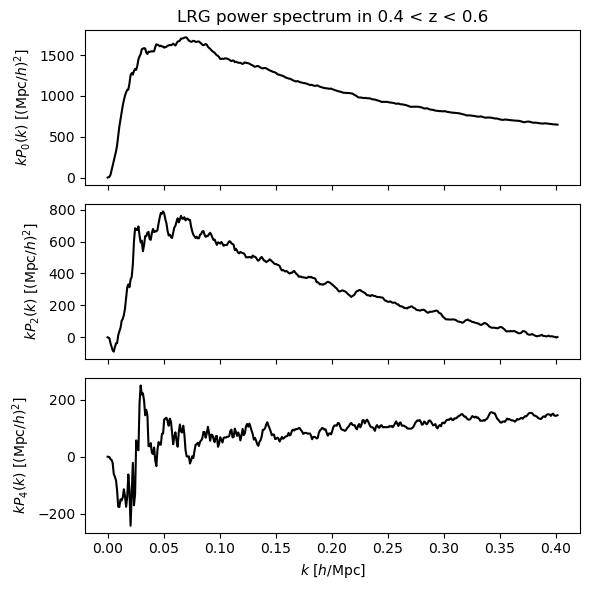

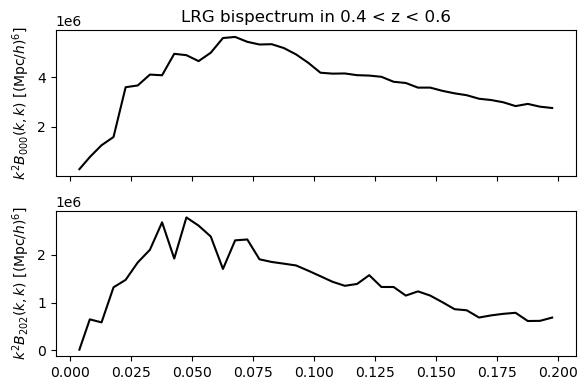

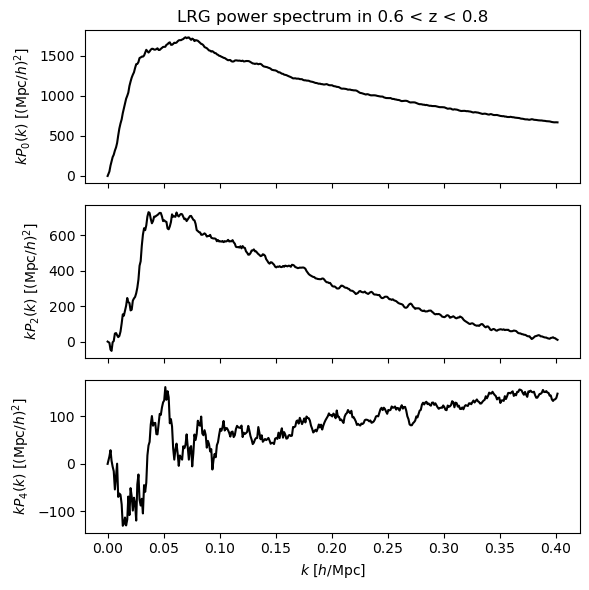

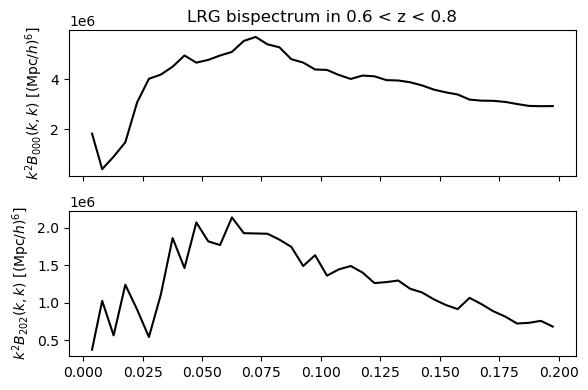

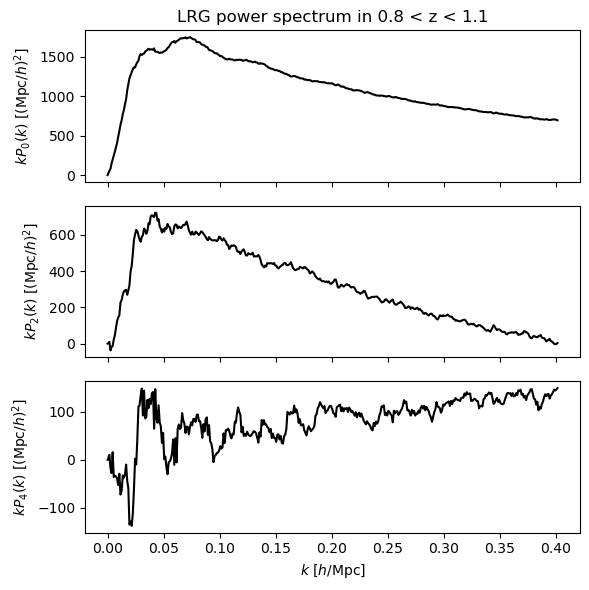

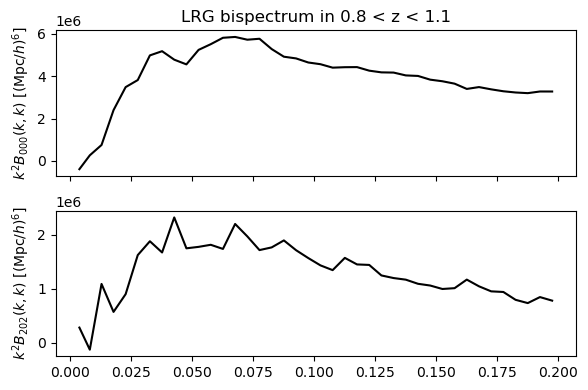

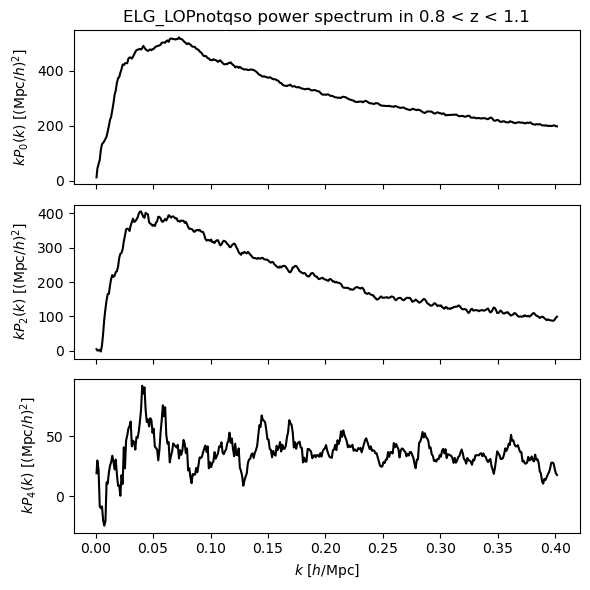

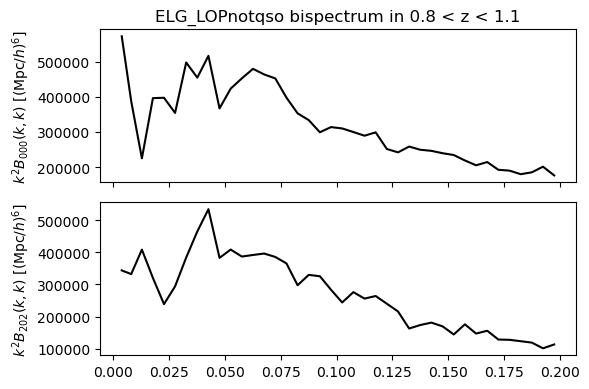

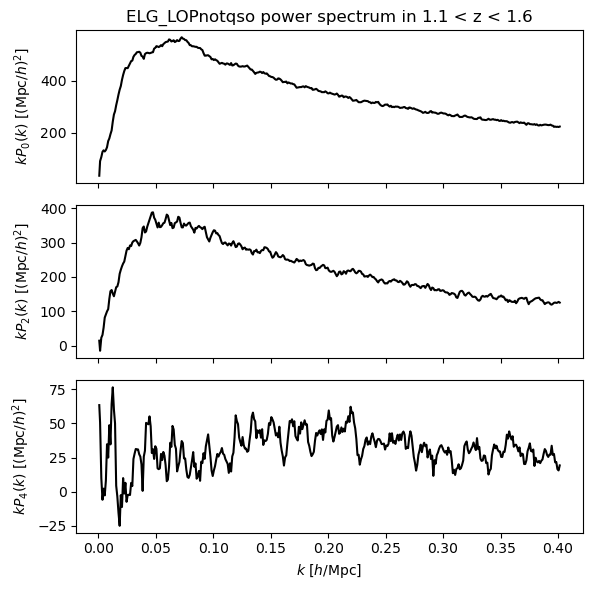

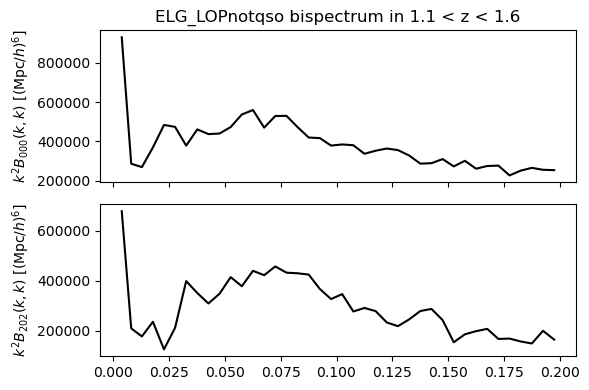

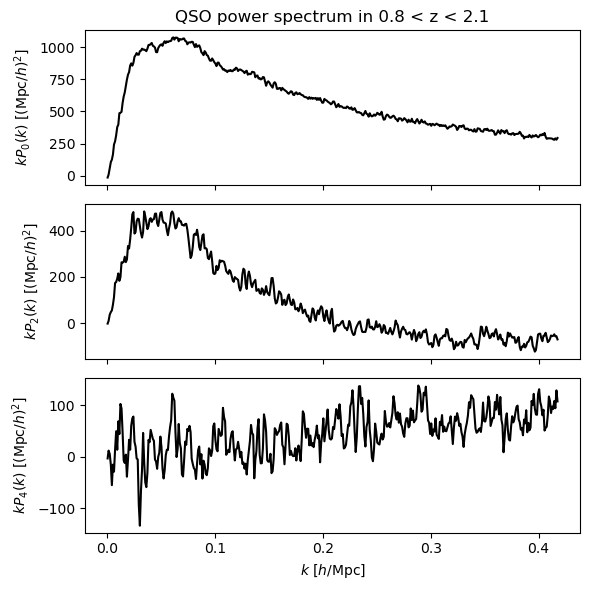

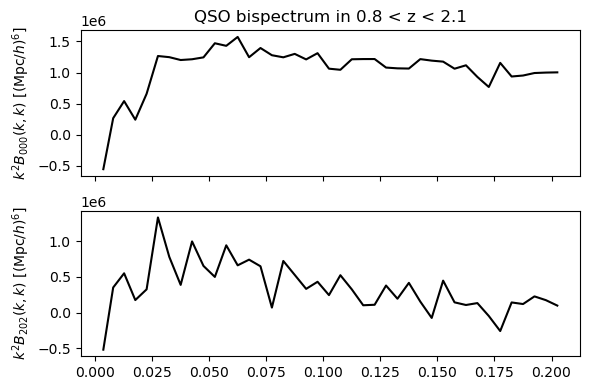

In [21]:
import os
import sys
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

import lsstypes as types

sys.path.insert(0, '../')
import tools

plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)

ext = 'png'
kinds = ['mesh2_spectrum', 'mesh3_spectrum']

meas_dir = Path(os.getenv('SCRATCH')) / 'clustering-measurements-checks_final'
for tracer in ['LRG', 'ELG_LOPnotqso', 'QSO']:
    for zrange in tools.propose_fiducial('zranges', tracer=tracer):
        imocks = 451 + np.arange(10)
        region = 'NGC'

        def get_mean_cov(kind):
            fns = [tools.get_measurement_fn(kind=kind, meas_dir=meas_dir, version='holi-v1-altmtl', tracer=tracer, zrange=zrange,
                                            region=region, imock=imock) for imock in imocks]
            fns = [fn for fn in fns if fn.exists()]
            stats = list(map(types.read, fns))
            return types.mean(stats), types.cov(stats)

        for kind in kinds:
            if kind == 'mesh2_spectrum':
                mean, cov = get_mean_cov(kind)
                ells = mean.ells
                fig, lax = plt.subplots(len(ells), figsize=(6, 6), sharex=True)
                lax[0].set_title(f'{tracer} power spectrum in {zrange[0]:.1f} < z < {zrange[1]:.1f}')
                for ill, ell in enumerate(ells):
                    ax = lax[ill]
                    ax.set_ylabel(rf'$k P_{ell:d}(k)$ [$(\mathrm{{Mpc}}/h)^2$]')
                    pole = mean.get(ell)
                    ax.plot(pole.coords('k'), pole.coords('k') * pole.value().real, color='k', linestyle='-')
                    #if ill == 0: ax.legend(frameon=False, ncol=2)
                lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
                basename = f'check_{kind}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}.{ext}'
                plt.tight_layout()
                fig.savefig(plot_dir / basename, bbox_inches='tight', pad_inches=0.1, dpi=200)
                plt.show()
            if kind == 'mesh3_spectrum':
                mean, cov = get_mean_cov(kind)
                ells = mean.ells
                fig, lax = plt.subplots(len(ells), figsize=(6, 4), sharex=True)
                lax[0].set_title(f'{tracer} bispectrum in {zrange[0]:.1f} < z < {zrange[1]:.1f}')
                for ill, ell in enumerate(ells):
                    ax = lax[ill]
                    ax.set_ylabel(rf'$k^2 B_{{{ell[0]:d}{ell[1]:d}{ell[2]:d}}}(k, k)$ [$(\mathrm{{Mpc}}/h)^6$]')
                    pole = mean.get(ell)
                    x = pole.coords('k')[..., 0]
                    ax.plot(x, x**2 * pole.value().real, color='k', linestyle='-')
                basename = f'check_{kind}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}.{ext}'
                plt.tight_layout()
                fig.savefig(plot_dir / basename, bbox_inches='tight', pad_inches=0.1, dpi=200)
                plt.show()
                
        